In [1]:
using MLDatasets
using ImageCore
using LinearAlgebra
using PyPlot
using Random
using Statistics
using Printf
using Quaternions
using JLD2, FileIO
using ProgressMeter
include("HyperRPNNs.jl")
rng = MersenneTwister(1234);

In [2]:
function cifar2gray(x)
    return round.(Int,255*(0.2989*x[:,:,1,1] + 0.5870*x[:,:,2,1]+ 0.1140*x[:,:,3,1]))
end

function gray2multistate(x,K)
    zsize = size(x)
    z = exp.(2.0*pi*x*im/K)[:]
    return hcat(real.(z),imag.(z)), zsize
end

function multistate2gray(y,K,ysize)
    z = y[:,1]+y[:,2]*im
    return reshape(Array{Int64}((round.(K*(2*pi.+angle.(z))./(2*pi))).%K),ysize)
end

function imnoise(img,noise_std = 0.1)
    return clamp.(img + noise_std*randn(rng, Float64, size(img)),0,1)
end

imnoise (generic function with 2 methods)

In [3]:
# load full training set
train_x, train_y = CIFAR10.traindata();
# Select the fundamental memory
P = 200
indFM = randperm(rng, size(train_x)[4])[1:P];
# Select one image from the fundamental memory set
iFMS=200


200

In [4]:
N = 32*32

#alpha = 20/N
alpha = 20
beta = -20

P = 200
K = 256


Nsim = 100
NoiseValues = range(0,stop=150,step=5)/255
Nnoise = length(NoiseValues)

SuccessCvMultistate_Sync = zeros(Int64,(Nnoise,))
SuccessCvMultistate_Seq = zeros(Int64,(Nnoise,))

@showprogress for s = 1:Nsim
    # Generate the fundamental memory set!
    indFM = randperm(rng, size(train_x)[4])[1:P]
    U = Array{Real}(undef,N,2,P)
    for i=1:P
        uc, usize = gray2multistate(cifar2gray(train_x[:,:,:,indFM[i]]),K)
        U[:,:,i] = uc
    end
    
    
    for i = 1:Nnoise
        # Generate a corrupted pattern
        imgx = cifar2gray(train_x[:,:,:,indFM[1]])
        imgxr = cifar2gray(imnoise(train_x[:,:,:,indFM[1]],NoiseValues[i]))
        x, xsize = gray2multistate(imgxr,K)
        
        # Recall using synchronous update

        y, Energy =  HyperRPNNs.Sync(HyperRPNNs.LambdaInner,[1,1],HyperRPNNs.csign,K,U,x,alpha,beta)
        imgy = multistate2gray(y,K,xsize)
        Error = norm(imgx-imgy)
        if Error<1.e-4
            SuccessCvMultistate_Sync[i] = SuccessCvMultistate_Sync[i] + 1
        end
        
        ## Recall using asynchronous update
        #y, Energy = HyperRPNNs.Seq(HyperRPNNs.LambdaInner,[1,1],HyperRPNNs.csign,K,Cinv,U,x,alpha,beta)
        #imgy = multistate2gray(y,K,xsize)
        #Error = norm(imgx-imgy)
        #if Error<1.e-4
        #    SuccessCvMultistate_Seq[i] = SuccessCvMultistate_Seq[i] + 1
        #end
    end
    @save "JLDs/CIFARCvMultistate.jld2" SuccessCvMultistate_Sync  NoiseValues Nsim
end

Progress: 100%|█████████████████████████████████████████| Time: 3:38:20


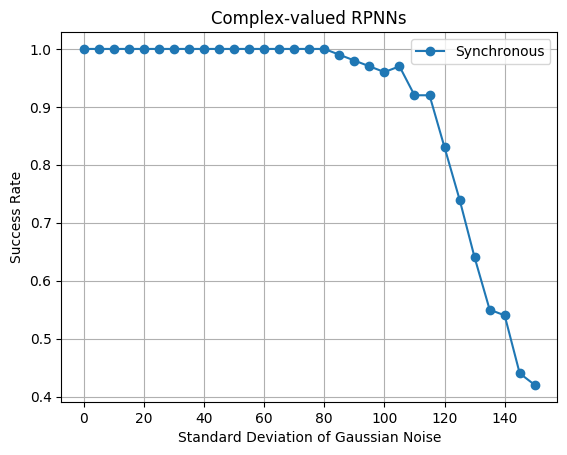

In [5]:
@load "JLDs/CIFARCvMultistate.jld2"
plot(255*NoiseValues,SuccessCvMultistate_Sync/Nsim, marker="o",label = "Synchronous")
#plot(255*NoiseValues,SuccessCvMultistate_Seq/Nsim, marker="s",label = "Asynchronous")
title("Complex-valued RPNNs")
xlabel("Standard Deviation of Gaussian Noise")
ylabel("Success Rate")
legend()
grid()